## Model 1 - ERC (Emotion Recognition in conversation)

#### Setup

In [1]:
! pip install transformers
! pip install sentence_transformers

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util

import pickle
import os

/home/utkarsh/miniconda3/envs/pytorch_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# disable CUDNN 

torch.backends.cudnn.enabled = False

DEVICE

device(type='cuda')

### Data *engneering*

### **Models**

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ERC_CNN(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, input_size, hidden_size, num_layers, mlp_hidden_size, output_size):
        super(ERC_CNN, self).__init__()
        """
        ERC-CNN Module combining CNN, BiLSTM, and MLP
        Input shape: (batch_size, in_channels, width, length)
        Output shape: (batch_size, seq_length, output_size)
        """
        # CNN layers
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=(1, 1))
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=(1, 1))

        # BiLSTM layer
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        
        # MLP layers
        self.fc1 = nn.Linear(hidden_size * 2, mlp_hidden_size)
        self.fc2 = nn.Linear(mlp_hidden_size, output_size)

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = self.conv2(x)

        # BiLSTM
        x = x.squeeze(1)  # Remove the singleton dimension
        x, _ = self.bilstm(x)

        # MLP
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

### DataLoader

In [5]:
from torch.utils.data import DataLoader, Dataset

'''
class MyDataset(Dataset):
    def __init__(self, json_path = 'train_file.json'):
        self.embedding_model = SentenceTransformer('all-mpnet-base-v2')
        self.train_data = pd.read_json(json_path)
        emotions = ['surprise', 'neutral', 'disgust', 'fear', 'sadness', 'anger', 'joy']
        self.emotion_dict = {}
        for i, emotion in enumerate(emotions):
            self.emotion_dict[emotion] = i

    def generate_cnn_embeddings(self, row):
        speakers = row['speakers']

        embeddings_list = self.embedding_model.encode(row['utterances'])

        speaker_index = {}
        index = 0
        for speaker in speakers:
            if speaker not in speaker_index:
                speaker_index[speaker] = index
                index += 1

        S = len(speaker_index)
        N = len(speakers)
        embeddings_tensor = np.zeros((max(10 , S), N, 768))
        for i, (speaker, embedding) in enumerate(zip(speakers, embeddings_list)):
            idx = speaker_index[speaker]
            embeddings_tensor[idx, i, :] = embedding
        return embeddings_tensor

    def gen_emotion_matrix(self, row):
        emotions = row['emotions']
        emotion_matrix = np.zeros((len(emotions), 7))
        for idx, emotion in enumerate(emotions):
            emotion_matrix[idx][self.emotion_dict[emotion]] = 1
        return emotion_matrix


    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, idx):
        X = self.generate_cnn_embeddings(self.train_data.iloc[idx])
        Y = self.gen_emotion_matrix(self.train_data.iloc[idx])
        return X, Y

'''

"\nclass MyDataset(Dataset):\n    def __init__(self, json_path = 'train_file.json'):\n        self.embedding_model = SentenceTransformer('all-mpnet-base-v2')\n        self.train_data = pd.read_json(json_path)\n        emotions = ['surprise', 'neutral', 'disgust', 'fear', 'sadness', 'anger', 'joy']\n        self.emotion_dict = {}\n        for i, emotion in enumerate(emotions):\n            self.emotion_dict[emotion] = i\n\n    def generate_cnn_embeddings(self, row):\n        speakers = row['speakers']\n\n        embeddings_list = self.embedding_model.encode(row['utterances'])\n\n        speaker_index = {}\n        index = 0\n        for speaker in speakers:\n            if speaker not in speaker_index:\n                speaker_index[speaker] = index\n                index += 1\n\n        S = len(speaker_index)\n        N = len(speakers)\n        embeddings_tensor = np.zeros((max(10 , S), N, 768))\n        for i, (speaker, embedding) in enumerate(zip(speakers, embeddings_list)):\n       

In [6]:
import json

class MyDataset(Dataset):
    def __init__(self, json_path='train_file.json'):
        with open(json_path, 'r') as file:
            self.data = json.load(file)
        self.embedding_model = SentenceTransformer('all-mpnet-base-v2')
        self.emotion_dict = {
            'surprise': 0, 'neutral': 1, 'disgust': 2,
            'fear': 3, 'sadness': 4, 'anger': 5, 'joy': 6
        }

    def generate_cnn_embeddings(self, conversation):
        speakers = [utterance['speaker'] for utterance in conversation]
        texts = [utterance['text'] for utterance in conversation]

        embeddings_list = self.embedding_model.encode(texts)
        
        speaker_index = {}
        for index, speaker in enumerate(speakers):
            if speaker not in speaker_index:
                speaker_index[speaker] = len(speaker_index)
        
        S = len(speaker_index)
        N = len(speakers)
        embeddings_tensor = np.zeros((max(10, S), N, 768))
        for i, (speaker, embedding) in enumerate(zip(speakers, embeddings_list)):
            idx = speaker_index[speaker]
            embeddings_tensor[idx, i, :] = embedding
        return embeddings_tensor

    def gen_emotion_matrix(self, conversation):
        emotions = [utterance['emotion'] for utterance in conversation]
        emotion_matrix = np.zeros((len(emotions), 7))
        for idx, emotion in enumerate(emotions):
            emotion_matrix[idx][self.emotion_dict[emotion]] = 1
        return emotion_matrix

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        conversation = self.data[idx]['conversation']
        X = self.generate_cnn_embeddings(conversation)
        Y = self.gen_emotion_matrix(conversation)
        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)


### Model

In [7]:
# Define parameters
batch_size = 1
speakers = 10  # max_speakers
num_utterances = 24  # dialogue_length
embedding_size = 768

cnn_mid_channels = 3
cnn_out_channels = 1

hidden_lstm = 64
layers_lstm = 1

inputs_mlp = hidden_lstm * 2
hidden_mlp = 64
output_mlp = number_of_emotions = 7


# Initialize the ERC_CNN class
model = ERC_CNN(in_channels=speakers,
                mid_channels=cnn_mid_channels,
                out_channels=cnn_out_channels,
                input_size=embedding_size,
                hidden_size=hidden_lstm,
                num_layers=layers_lstm,
                mlp_hidden_size=hidden_mlp,
                output_size=output_mlp)

# set the layer bilstm to not require gradients
# for param in model.bilstm.parameters():
#     param.requires_grad = False

# input_tensor = torch.randn(batch_size, speakers, num_utterances, embedding_size)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define your model, loss function, and optimizer
folder_path = "/content/drive/MyDrive/IIITD/Courses/nlp/Assignment 4/"
folder_path = ""

path_train_file = folder_path+"train_file.json"

dataset = MyDataset(path_train_file)
criterion = nn.CrossEntropyLoss().to(DEVICE)

model = ERC_CNN(in_channels=speakers,
                mid_channels=cnn_mid_channels,
                out_channels=cnn_out_channels,
                input_size=embedding_size,
                hidden_size=hidden_lstm,
                num_layers=layers_lstm,
                mlp_hidden_size=hidden_mlp,
                output_size=output_mlp).to(DEVICE)

for param in model.bilstm.parameters():
    param.requires_grad = False

optimizer = optim.Adam(model.parameters(), lr=0.001)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

val_dataset = MyDataset(folder_path+"val_file.json")
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

train_losses = []
val_losses = []

# if the model is already trained, load the model
if os.path.exists(folder_path+"M1_assignment.pth"):
    model.load_state_dict(torch.load(folder_path+"M1_assignment.pth"))



num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in tqdm(enumerate(dataloader)):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs.float())

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Print statistics
        running_loss += loss.item() * inputs.size(0)

        # tqdm.write(f"Training in Progress: {i+1}/{6000}")

    # Print average loss for the epoch
    epoch_loss = running_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    train_losses.append(epoch_loss)


    running_loss = 0.0
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in tqdm(enumerate(val_dataloader)):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(val_dataloader.dataset)
    print(f"Validation Loss: {epoch_loss:.4f}")

    val_losses.append(epoch_loss)

    if epoch % 2 == 0:
        torch.save(model.state_dict(), folder_path+f"1_erc_cnn_model{epoch}.pth")

1236it [00:21, 58.45it/s]


Epoch [1/5], Loss: 3.3362


138it [00:01, 70.34it/s]


Validation Loss: 2.9584


1236it [00:20, 60.65it/s]


Epoch [2/5], Loss: 3.0123


138it [00:01, 70.58it/s]


Validation Loss: 2.8890


1236it [00:20, 60.41it/s]


Epoch [3/5], Loss: 2.9204


138it [00:01, 70.09it/s]


Validation Loss: 2.8549


1236it [00:20, 59.27it/s]


Epoch [4/5], Loss: 2.8686


138it [00:01, 70.60it/s]


Validation Loss: 2.8401


1236it [00:20, 59.67it/s]


Epoch [5/5], Loss: 2.8346


138it [00:01, 69.75it/s]

Validation Loss: 2.8361


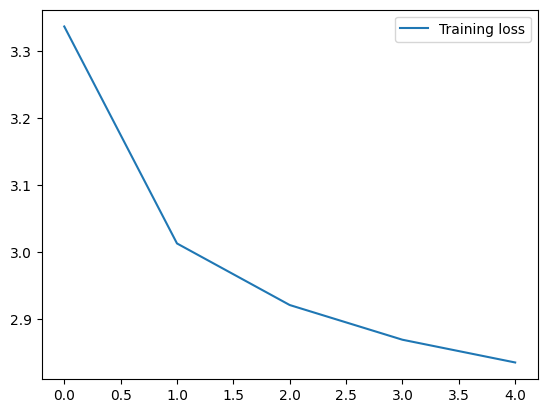

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
#plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()


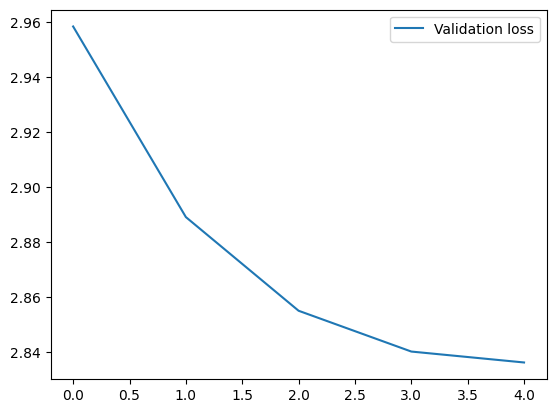

In [10]:
plt.plot(val_losses, label='Validation loss')
plt.legend()

plt.show()


In [11]:
# save the model
torch.save(model.state_dict(), folder_path+"M1.pth")

In [12]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ERC_CNN(in_channels=speakers,
                mid_channels=cnn_mid_channels,
                out_channels=cnn_out_channels,
                input_size=embedding_size,
                hidden_size=hidden_lstm,
                num_layers=layers_lstm,
                mlp_hidden_size=hidden_mlp,
                output_size=output_mlp)

state_dict = torch.load('M1.pth')
model.load_state_dict(state_dict)

model = model.to(DEVICE)

l = ['surprise', 'neutral', 'disgust', 'fear', 'sadness', 'anger', 'joy']

model.eval()

ERC_CNN(
  (conv1): Conv2d(10, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
  (bilstm): LSTM(768, 64, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=7, bias=True)
)

In [13]:
import torch
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def get_F1(model , dataloader , DEVICE):
    all_predicted=[]
    all_true=[]

    for inputs,labels in tqdm(dataloader):
        inputs=inputs.to(DEVICE)
        labels=labels.to(DEVICE)
        with torch.no_grad():
            outputs=model(inputs.float())
        predicted=torch.argmax(outputs,dim=2).cpu().numpy().flatten()
        true_labels=torch.argmax(labels,dim=2).cpu().numpy().flatten()
        all_predicted.extend(predicted)
        all_true.extend(true_labels)

    f1_scores_dict = {
        'surprise': f1_score(all_true, all_predicted, labels=[0], average='weighted'),
        'neutral': f1_score(all_true, all_predicted, labels=[1], average='weighted'),
        'disgust': f1_score(all_true, all_predicted, labels=[2], average='weighted'),
        'fear': f1_score(all_true, all_predicted, labels=[3], average='weighted'),
        'sadness': f1_score(all_true, all_predicted, labels=[4], average='weighted'),
        'anger': f1_score(all_true, all_predicted, labels=[5], average='weighted'),
        'joy': f1_score(all_true, all_predicted, labels=[6], average='weighted'),
        'overall': f1_score(all_true, all_predicted, average='weighted')
    }    

    cm = confusion_matrix(all_true, all_predicted)

    print(f1_scores_dict)

    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=l, yticklabels=l)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    from sklearn.metrics import accuracy_score , precision_score , recall_score
    acc = accuracy_score(all_true, all_predicted)
    p = precision_score(all_true, all_predicted, average='macro')
    r = recall_score(all_true, all_predicted, average='macro')
    print("ACCURACY: ", acc)
    print("PRECISION: " , p)
    print("RECALL: " , r)

    return f1_scores_dict , acc , p , r

100%|██████████| 1236/1236 [00:18<00:00, 67.15it/s]


{'surprise': 0.4906832298136645, 'neutral': 0.7716312056737589, 'disgust': 0.4437689969604863, 'fear': 0.366412213740458, 'sadness': 0.4997455470737913, 'anger': 0.575084175084175, 'joy': 0.5924220963172805, 'overall': 0.6360472472521684}


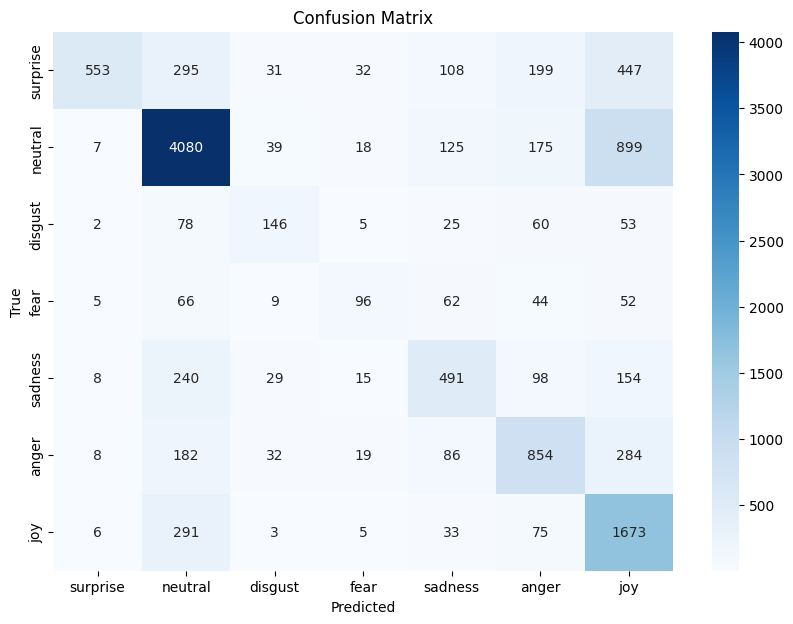

ACCURACY:  0.6418638692363992
PRECISION:  0.6134611777964306
RECALL:  0.5197402708911579


{'surprise': 0.4906832298136645,
 'neutral': 0.7716312056737589,
 'disgust': 0.4437689969604863,
 'fear': 0.366412213740458,
 'sadness': 0.4997455470737913,
 'anger': 0.575084175084175,
 'joy': 0.5924220963172805,
 'overall': 0.6360472472521684}

In [14]:
# TRAINING 
dataset = MyDataset("train_file.json")
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

train_f1 , acc_train , precision_train , recall_train = get_F1(model , dataloader , DEVICE)

train_f1

100%|██████████| 138/138 [00:01<00:00, 69.57it/s]


{'surprise': 0.3192488262910798, 'neutral': 0.7688356164383562, 'disgust': 0.39506172839506176, 'fear': 0.41791044776119396, 'sadness': 0.43317972350230416, 'anger': 0.5675675675675674, 'joy': 0.5747508305647842, 'overall': 0.6034078621884279}


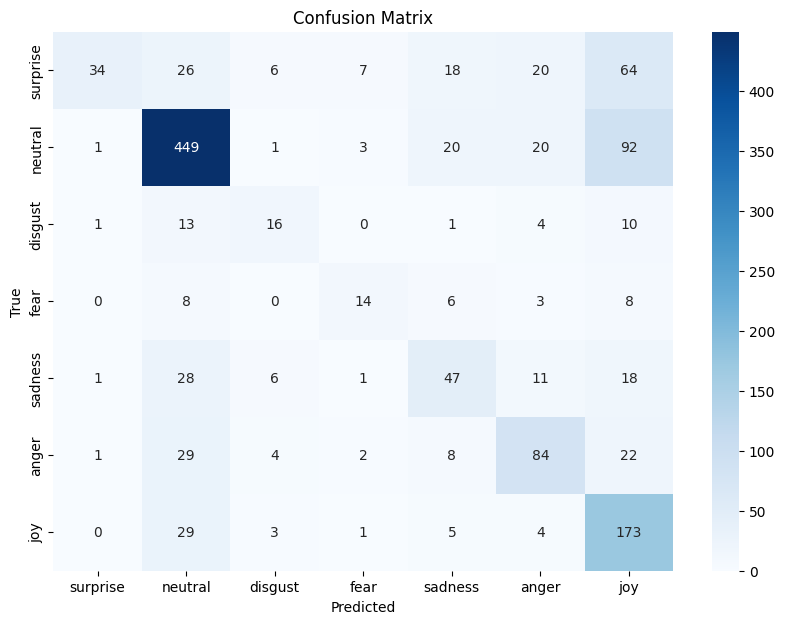

ACCURACY:  0.6180030257186082
PRECISION:  0.58294984098929
RECALL:  0.4941887504063924


{'surprise': 0.3192488262910798,
 'neutral': 0.7688356164383562,
 'disgust': 0.39506172839506176,
 'fear': 0.41791044776119396,
 'sadness': 0.43317972350230416,
 'anger': 0.5675675675675674,
 'joy': 0.5747508305647842,
 'overall': 0.6034078621884279}

In [15]:
# VALIDATION
val_dataset = MyDataset("val_file.json")
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_f1  , acc_val , precision_val , recall_val = get_F1(model , val_dataloader , DEVICE)

test_f1 

In [16]:
# make a csv with the following columns: 
# current-date-time , model-name , epochs , f1-score-train , f1-score-test , precision-train , precision-test , recall-train , recall-test , accuracy-train , accuracy-test

import csv
from datetime import datetime

current_date_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
model_name = "M1"
epochs = num_epochs

with open('results.csv', mode='a') as file:
    writer = csv.writer(file)
    writer.writerow([current_date_time, model_name, epochs, train_f1, test_f1, precision_train, precision_val, recall_train, recall_val, acc_train, acc_val])

In [17]:
import pandas as pd 

df = pd.read_csv('results.csv')

# disable truncation 
pd.set_option('display.max_rows', None)

# dont truncate any entry 

pd.set_option('display.max_colwidth', None)

df

,2024-04-25 22:24:14,M1,5,"{'surprise': 0.4906832298136645, 'neutral': 0.7716312056737589, 'disgust': 0.4437689969604863, 'fear': 0.366412213740458, 'sadness': 0.4997455470737913, 'anger': 0.575084175084175, 'joy': 0.5924220963172805, 'overall': 0.6360472472521684}","{'surprise': 0.3192488262910798, 'neutral': 0.7688356164383562, 'disgust': 0.39506172839506176, 'fear': 0.41791044776119396, 'sadness': 0.43317972350230416, 'anger': 0.5675675675675674, 'joy': 0.5747508305647842, 'overall': 0.6034078621884279}",0.6134611777964306,0.58294984098929,0.5197402708911579,0.4941887504063924,0.6418638692363992,0.6180030257186082


# Human evaluation

In [18]:
# take some utterane with emotion as "surprise" and predict its output using the model 

utterences = []

for emotion in ['surprise' , 'fear' , 'neutral']: 
    for q in range(3): 

        import json
        import random

        with open("train_file.json", "r") as file:
            data = json.load(file)

        surprise_data = []
        for i in data:
            for j in i['conversation']:
                if j['emotion'] == emotion:
                    surprise_data.append(j)

        random_surprise = random.choice(surprise_data)

        print(random_surprise)

        utterance = random_surprise['text']
        speaker = random_surprise['speaker']

        model = ERC_CNN(in_channels=speakers, mid_channels=cnn_mid_channels, out_channels=cnn_out_channels, input_size=embedding_size, hidden_size=hidden_lstm, num_layers=layers_lstm, mlp_hidden_size=hidden_mlp, output_size=output_mlp)

        state_dict = torch.load('M1.pth')

        model.load_state_dict(state_dict)

        model = model.to(DEVICE)

        model.eval()


        model.eval()
        with torch.no_grad():
            inputs = dataset.generate_cnn_embeddings([random_surprise])
            inputs = torch.tensor(inputs, dtype=torch.float32)

            labels = dataset.gen_emotion_matrix([random_surprise])
            labels = torch.tensor(labels, dtype=torch.float32)

            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs.float())

            prediction = torch.argmax(outputs).cpu().numpy().flatten()
            true_labels = torch.argmax(labels).cpu().numpy().flatten()

            dict = {
                0: 'surprise',
                1: 'neutral',
                2: 'disgust',
                3: 'fear',
                4: 'sadness',
                5: 'anger',
                6: 'joy'
            }

            print("Predicted: ", dict[prediction[0]])
            print("True Labels: ", dict[true_labels[0]])

{'utterance_ID': 3, 'text': 'Wow , you guys , this is big .', 'speaker': 'Rachel', 'emotion': 'surprise'}
Predicted:  joy
True Labels:  surprise
{'utterance_ID': 1, 'text': 'I can not believe it !', 'speaker': 'Phoebe', 'emotion': 'surprise'}
Predicted:  surprise
True Labels:  surprise
{'utterance_ID': 9, 'text': 'Oh my God .', 'speaker': 'Rachel', 'emotion': 'surprise'}
Predicted:  surprise
True Labels:  surprise
{'utterance_ID': 10, 'text': 'This actor friend and he would kill me if he thought I was doing this umm , but umm would it be possible for him to get an audition for your movie say on Thursday ?', 'speaker': 'Chandler', 'emotion': 'fear'}
Predicted:  joy
True Labels:  fear
{'utterance_ID': 11, 'text': 'No !', 'speaker': 'Phoebe', 'emotion': 'fear'}
Predicted:  anger
True Labels:  fear
{'utterance_ID': 8, 'text': 'Oh it is Bing , sir . I am sorry , I was just ah ...', 'speaker': 'Chandler', 'emotion': 'fear'}
Predicted:  sadness
True Labels:  fear
{'utterance_ID': 12, 'text': 